# Implied Volatility and Greeks of 'At The Money' Index Options, Live & Expired

The Python Class below (i) automatically find the Option (of choice), live or expired, closest to [At The Money (ATM)](https://www.investopedia.com/terms/a/atthemoney.asp) and (ii) calculate its [Implied Volatility](https://www.investopedia.com/terms/i/iv.asp) & [Greeks](https://www.investopedia.com/terms/g/greeks.asp) all while using uses [*Type Hints*](https://peps.python.org/pep-3107/#use-cases).
We focus below on Future (Monthly) Options on the Index '.STOXX50E' (EURO STOXX 50 EUR PRICE INDEX) ('[EUREX](https://go.refinitiv.com/?u=Y3B1cmw6Ly9hcHBzLmNwLi9BcHBzL0luZGV4Lz9zPS5TVE9YWDUwJnN0PVJJQw%3D%3D&title=.STOXX50%20OV&key=bUq%2BNCiQGAcHQjSNEkJSlZLTgjo9cios8rz4heIBiU8%3D)') and '.SPX' ([S&P 500 INDEX](https://go.refinitiv.com/?u=Y3B1cmw6Ly9hcHBzLmNwLi9BcHBzL0luZGV4Lz9zPS5TUFgmc3Q9UklDIy8%3D&title=.SPX%20OV&key=21C0FJ4FZsZ4s9b6HR4mDSAIHId9rxFOgaCjslcqIVk%3D)), although you can apply the logic below for another index.
To find the ATM instrument, we simply and efficiently use the [Search API](https://developers.refinitiv.com/en/article-catalog/article/building-search-into-your-application-workflow).
Usually, the calculation of the Black-Scholes-Merton model's Implied Volatility involves numerical techniques, since it is not a [closed equation](https://en.wikipedia.org/wiki/Closed-form_expression) ([unless restricting assumptions that log returns follow a standard normal distribution with mean is zero, $\mu$ = 0, and standard deviation is zero, $\sigma$ = 1, are made](https://corporatefinanceinstitute.com/resources/derivatives/black-scholes-merton-model/)). If we used these techniques in calculating each Implied Volatility value on our computer, it would take several seconds - if not minutes - for each data point computed. I have chosen to use the [Instrument Pricing Analytics (IPA)](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/documentation#ipa-financial-contracts-option-contracts-eti) service in the Python [Refinitiv Data Library](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-libraries) instead, as this service allows me to send model specifications (and variables) and receive several (up to 100) computed Implied Volatility values in one go - in a few seconds. Not only does this save a great deal of time, but also many lines of code! Fianlly, we will put it all in one function.

There are 3 layers in the Refinitiv Data Library: [Delivery](https://github.com/LSEG-API-Samples/Example.DataLibrary.Python/tree/main/Examples/3-Delivery), [Content](https://github.com/LSEG-API-Samples/Example.DataLibrary.Python/tree/main/Examples/2-Content) and [Access](https://github.com/LSEG-API-Samples/Example.DataLibrary.Python/tree/main/Examples/1-Access). This notebook demonstrates how to use the Definition object of the Delivery layer in conjunction with with the functions `get_data` and `get_history` and the Instrument Pricing Analytics (IPA) product.

The Delivery layer provides a simplified data request interface for REST APIs, designed for FinCoders.

#### IPA

IPA (otherwise known as the Quantitative Analytics (QA) API Family) is a powerful product provided by LSEG through its Data Platform REST APIs and [Data Libraries](https://developers.lseg.com/en/api-catalog?x1=w_products&q1=devportal%3Aproducts%2Frefinitiv-data-libraries) that provides calculators for financial operations.

#### Learn more

To learn more about the Refinitiv Data Library for Python please join the Refinitiv Developer Community. By [registering](https://developers.refinitiv.com/iam/register) and [logging](https://developers.refinitiv.com/content/devportal/en_us/initCookie.html) into the Refinitiv Developer Community portal you will have free access to a number of learning materials like 
 [Quick Start guides](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/quick-start), 
 [Tutorials](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/tutorials), 
 [Documentation](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/documentation)
 and much more.

 You may also visit the [API Playground](https://apidocs.refinitiv.com/Apps/ApiDocs) to get more examples, find  end points and download Swagger files

#### Getting Help and Support

If you have any questions regarding using the API, please post them on 
the [Refinitiv Data Q&A Forum](https://community.developers.refinitiv.com/spaces/321/index.html). 
The Refinitiv Developer Community will be happy to help. 

----

## Some Imports to start with

In [3]:
import refinitiv.data as rd
from refinitiv.data.content import historical_pricing 
from refinitiv.data.content import search  # We will use this Python Class in `rd` to fid the instrument we are after, closest to At The Money.
import refinitiv.data.content.ipa.financial_contracts as rdf  # We're going to need this to use the content layer of the RD library and the calculators of greeks and Impl Volat in Instrument Pricing Analytics (IPA) and Exchange Traded Instruments (ETI)
from refinitiv.data.content.ipa.financial_contracts import option  # We're going to need this to use the content layer of the RD library and the calculators of greeks and Impl Volat in IPA & ETI

import pandas as pd
import time # This is to pause our code when it needs to slow down
import numpy as np  # We need `numpy` for mathematical and array manipilations.
import pandas as pd  # We need `pandas` for datafame and array manipilations.
import calendar  # We use `calendar` to identify holidays and maturity dates of intruments of interest.
import pytz  # We use `pytz` to manipulate time values aiding `calendar` library. to import its types, you might need to run `!python3 -m pip install types-pytz`
import pandas_market_calendars as mcal  # Used to identify holidays. See `https://github.com/rsheftel/pandas_market_calendars/blob/master/examples/usage.ipynb` for info on this market calendar library
from datetime import datetime, timedelta, date, timezone  # We use these to manipulate time values
from dateutil.relativedelta import relativedelta  # We use `relativedelta` to manipulate time values aiding `calendar` library.

from typing import Generator, Any
from types import ModuleType  # FrameType, TracebackType

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.figure
import plotly
import plotly.graph_objects as go

from pytz.tzinfo import DstTzInfo, StaticTzInfo
class _UTCclass:
        pass


class IndxImpVolatNGreeksIPACalc():  # All about Type Hints here: https://realpython.com/python-type-checking/#static-type-checking

    def __init__(  # Constroctor
        self,
        index_underlying: str = ".STOXX50E",
        call_put: str = 'Call',
        time_of_calc_datetime: datetime = datetime.now(),  # Here we allow for historical analysis.
        after: int = 15,
        mcal_get_cal: str = 'EUREX',
        interval: rd.content.historical_pricing.Intervals = rd.content.historical_pricing.Intervals.TEN_MINUTES
        ) -> None:  # self should be omitted from the annotation when it is given as a comment, and __init__() should be marked as -> None: https://peps.python.org/pep-0484/
        '''
        IndxImpVolatNGreeksIPACalc() Python Class Version 2.0:
            This Class was built and tested in Python 3.10.5.

        Dependencies
        ----------------------------------------------
        refinitiv.data version 1.2.0 with an open session (more on https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/quick-start#getting-started-with-python)
        numpy version 1.23.1
        pandas version 1.3.5
        pandas_market_calendarspytz version 4.1.4
        requests version 2022.1
        plotly version 2.28.1
        pytz 2023.3
        typing (native to Python in versions 3.10 and above)
        types (native to Python in versions 3.10 and above)
        datetime (native to Python)

        Changes
        ----------------------------------------------
        Changed from Version 1.0 to 2.0: Re-wrote the Class adding Type Hints
        '''

        import refinitiv.data as rd
        from refinitiv.data.content import historical_pricing 
        from refinitiv.data.content import search  # We will use this Python Class in `rd` to fid the instrument we are after, closest to At The Money.
        import refinitiv.data.content.ipa.financial_contracts as rdf  # We're going to need this to use the content layer of the RD library and the calculators of greeks and Impl Volat in Instrument Pricing Analytics (IPA) and Exchange Traded Instruments (ETI)
        from refinitiv.data.content.ipa.financial_contracts import option  # We're going to need this to use the content layer of the RD library and the calculators of greeks and Impl Volat in IPA & ETI

        import pandas as pd
        import numpy as np  # We need `numpy` for mathematical and array manipilations.
        import pandas as pd  # We need `pandas` for datafame and array manipilations.
        import calendar  # We use `calendar` to identify holidays and maturity dates of intruments of interest.
        import pytz  # We use `pytz` to manipulate time values aiding `calendar` library. to import its types, you might need to run `!python3 -m pip install types-pytz`
        import pandas_market_calendars as mcal  # Used to identify holidays. See `https://github.com/rsheftel/pandas_market_calendars/blob/master/examples/usage.ipynb` for info on this market calendar library
        from datetime import datetime, timedelta, date, timezone  # We use these to manipulate time values
        from dateutil.relativedelta import relativedelta  # We use `relativedelta` to manipulate time values aiding `calendar` library.
        import requests  # We'll need this to send requests to servers vie a the delivery layer - more on that below

        from typing import Generator, Any
        from types import ModuleType  # FrameType, TracebackType

        from IPython.display import display


        holidays: tuple[date] = mcal.get_calendar(mcal_get_cal).holidays().holidays
        c: calendar.Calendar = calendar.Calendar(firstweekday=calendar.SATURDAY)
        exp_dates: dict[int, list[Any]]; _date: date; i_int: int
        _date = c.monthdatescalendar(time_of_calc_datetime.year, 1)[2][-1]
        if _date in holidays:  # check if found date is an holiday and get the previous date if it is
            _date = _date + timedelta(-1)
        exp_dates = {time_of_calc_datetime.year: [_date]}
        for i_int in range(2, 13):
            _date = c.monthdatescalendar(time_of_calc_datetime.year, i_int)[2][-1]
            if _date in holidays:  # check if found date is an holiday and get the previous date if it is
                _date = _date + timedelta(-1)
            exp_dates[time_of_calc_datetime.year].append(_date)  # append the date to the dictionary
        

        # Setting instance attributes and methods of class `IndxImpVolatNGreeksIPACalc`
        self.full_dates_at_calc_time: dict = exp_dates
        self.after: int = after
        self.mcal_get_cal: str = mcal_get_cal
        self.index_underlying: str = index_underlying
        self.call_put: str = call_put
        self.interval: rd.content.historical_pricing.Intervals = interval
        self.full_dates_at_calc_time_datetime: list[datetime] = [
            datetime(i_date.year, i_date.month, i_date.day)
            for i_date in self.full_dates_at_calc_time[
                list(self.full_dates_at_calc_time.keys())[0]]]
        self.expiry_date_of_intrst: date = [
            i_date for i_date in self.full_dates_at_calc_time_datetime
            if i_date > time_of_calc_datetime + relativedelta(days=self.after)][0]
        self.time_of_calc_datetime: date = time_of_calc_datetime


    def get_exp_dates(
        self,
        year: int = datetime.now().year,
        days: bool = True,
        mcal_get_calendar: str = 'EUREX'
        ) -> dict[int, list[date | str]]:
        '''
        IndxImpVolatNGreeksIPACalc().get_exp_dates Version 4.0: get_exp_dates(self, year: int = datetime.now().year, days: bool = True, mcal_get_calendar: str = 'EUREX') -> dict[int, date | str]:

        This function gets expiration dates for a year for NDX options, which are the 3rd Fridays of each month.

        Changes
        ----------------------------------------------
        Changed from Version 1.0 to 2.0: Jonathan Legrand changed Haykaz Aramyan's original code to allow
            (i) for the function's holiday argument to be changed, and defaulted to 'EUREX' as opposed to 'CBOE_Index_Options' and
            (ii) for the function to output full date objects as opposed to just days of the month if agument `days=True`.

        Changed from Version 2.0 to 3.0:
            Jonathan Legrand changed this function to reflect the fact that it can be used for indexes other than EUREX.

        Changed from Version 3.0 to 4.0:
            Jonathan Legrand changed this function to be in line with PEP 3107 (type hints) and added cosmetic changes (e.g.: name of functions and Class they're found in).

        Parameters
        -----------------------------------------------
        Input:
            year: year for which expiration days are requested

            mcal_get_calendar: String of the calendar for which holidays have to be taken into account. More on this calendar (link to Github checked 2022-10-11): https://github.com/rsheftel/pandas_market_calendars/blob/177e7922c7df5ad249b0d066b5c9e730a3ee8596/pandas_market_calendars/exchange_calendar_cboe.py

            days: If True, only days of the month is outputed, else it's dataeime objects

        Output
        -----------------------------------------------
            dates: dictionary of expiration days for each month of a specified year in datetime.date format.
        '''

        # get CBOE market holidays
        holidays: tuple[date] = mcal.get_calendar(mcal_get_calendar).holidays().holidays

        # set calendar starting from Saturday
        c: calendar.Calendar = calendar.Calendar(firstweekday=calendar.SATURDAY)

        # get the 3rd Friday of each month
        exp_dates: dict[int, list[Any]]; _date: date; i_int: int

        _date = c.monthdatescalendar(year, 1)[2][-1]
        if _date in holidays: # check if found date is an holiday and get the previous date if it is
            _date = _date + timedelta(-1)
        if days:
            exp_dates = {year:[_date.day]}
        else:
            exp_dates = {year: [_date]}
        for i_int in range(2, 13):
            _date = c.monthdatescalendar(year, i_int)[2][-1]
            if _date in holidays: # check if found date is an holiday and get the previous date if it is
                _date = _date + timedelta(-1)
            # append the date to the dictionary
            if days:
                exp_dates[year].append(_date.day)
            else:
                exp_dates[year].append(_date)

        return exp_dates


    def exp_RIC_check(
        self,
        ric: str,
        maturity: date,
        debug: bool,
        date_from: int = 600,
        ) -> tuple[str, pd.DataFrame]:
        """
        Support Function used within other functions in `OptionRIC` Class.
        """

        maturity_dtime: pd.Timestamp = pd.Timestamp(maturity)
        sdate: str; edate: str
        if pd.Timestamp(maturity) < datetime.now():
            sdate = (maturity_dtime - timedelta(date_from)).strftime('%Y-%m-%d')
            edate = maturity_dtime.strftime('%Y-%m-%d')
        else:
            sdate = (datetime.now() - timedelta(90)).strftime('%Y-%m-%d')
            edate = datetime.now().strftime('%Y-%m-%d')
        if debug:
            print(f"Check_RIC's (ric, sdate, edate) = ('{ric}', '{sdate}', '{edate}')")

        # Now things are getting tricky.
        # Certain Expiered Options do not have 'TRDPRC_1' data historically. Some don't have 'SETTLE'. Some have both...
        # The below should capture 'SETTLE' when it is available, but 'TRDPRC_1' might still be present in these instances.
        # So we will need to build a logic to focus on the series with the most datapoints.
        # If there's twice as few 'TRDPRC_1' data points as there are days, I consider
        # that to be too little data, and we then ask for 'SETTLE', then MID (calculated with 'ASK' and 'BID').
        prices: pd.DataFrame

        try:
            prices = rd.content.historical_pricing.summaries.Definition(
                universe=ric,
                start=sdate,
                end=edate,
                interval=self.interval,
                fields=['TRDPRC_1', 'SETTLE', 'BID', 'ASK']
                ).get_data().data.df
            if debug:
                print(f"exp_RIC_check prices:")
                display(prices)
        except:
            if debug:
                print(f"Code failed on step retrieving rd.content.historical_pricing.summaries.Definition(universe='{ric}', start='{sdate}', end='{edate}', interval='{self.interval}', fields=['TRDPRC_1', 'SETTLE', 'BID', 'ASK']).get_data().data.df")
        pr_cnt: pd.Series = prices.count()
        if debug:
            print("\n")
            print("prices1")
            display(prices)
            print("pr_cnt")
            display(pr_cnt)
            print("\n")
        if pr_cnt.TRDPRC_1 > 0:
            prices = pd.DataFrame(
                data={'TRDPRC_1': prices.TRDPRC_1}).dropna()
        elif pr_cnt.SETTLE > 0:
            prices = pd.DataFrame(
                data={'SETTLE': prices.SETTLE}).dropna()
        elif pr_cnt.BID > 0:
            prices = pd.DataFrame(
                data={'MID': (prices.BID + prices.ASK)/2}).dropna()
        prices.columns.name = ric

        return ric, prices


    def get_exp_asset_and_exchange(
        self,
        exchg_srch_top_nu_srch_results: int = 100
        ) -> dict[str, str]:
        """
        Support Function used within other functions in `OptionRIC` Class.
        """

        asset_in_ric: dict[str, dict[str, str]] = {
            'SSMI':     {'EUX': 'OSMI'},
            'GDAXI':    {'EUX': 'GDAX'},
            'ATX':      {'EUX': 'FATXA'},
            'STOXX50E': {'EUX': 'STXE'},
            'FTSE':     {'IEU': 'LFE', 'EUX': 'OTUK'},
            'N225':     {'OSA': 'JNI'},
            'TOPX':     {'OSA': 'JTI'}}

        i_dct_s_i: list[dict[str, str | int]]  # Is this needed for list comprehentions?
        exchange: list[str] = [
            i_dct_s_i['Label'] for i_dct_s_i in search.Definition(
                query=self.index_underlying,
                filter="SearchAllCategory eq 'Options' and Periodicity eq 'Monthly' ",
                select=' RIC, DocumentTitle, UnderlyingQuoteRIC, Periodicity, ExchangeCode',
                navigators="ExchangeCode",
                top=exchg_srch_top_nu_srch_results
                ).get_data().data.raw["Navigators"]["ExchangeCode"]['Buckets']]

        asset_exchange: dict[str, str] = {}
        asset: str
        if self.index_underlying[0] != '.':
            asset = self.index_underlying.split('.')[0]
        else:
            asset = self.index_underlying[1:]
        for exch in exchange:
            if asset in asset_in_ric:
                asset_exchange[exch] = asset_in_ric[asset][exch]
            else:
                asset_exchange[exch] = asset

        return asset_exchange


    def get_exp_optn_strike_RIC(
        self,
        exch: str,
        strike: float
        ) -> str:

        strike_ric: str; int_part: int; dec_part: str
        if exch == 'OPQ':
            if type(strike) == float:
                int_part = int(strike)
                dec_part = str(str(strike).split('.')[1])
            else:
                int_part = int(strike)
                dec_part = '00'
            if int(strike) < 10:
                strike_ric = '00' + str(int_part) + dec_part
            elif int_part >= 10 and int_part < 100:
                strike_ric = '0' + str(int_part) + dec_part
            elif int_part >= 100 and int_part < 1000:
                strike_ric = str(int_part) + dec_part
            elif int_part >= 1000 and int_part < 10000:
                strike_ric = str(int_part) + '0'
            elif int_part >= 10000 and int_part < 20000:
                strike_ric = 'A' + str(int_part)[-4:]
            elif int_part >= 20000 and int_part < 30000:
                strike_ric = 'B' + str(int_part)[-4:]
            elif int_part >= 30000 and int_part < 40000:
                strike_ric = 'C' + str(int_part)[-4:]
            elif int_part >= 40000 and int_part < 50000:
                strike_ric = 'D' + str(int_part)[-4:]

        elif exch == 'HKG' or exch == 'HFE':
            if self.index_underlying[0] == '.':
                strike_ric = str(int(strike))
            else:
                strike_ric = str(int(strike * 100))

        elif exch == 'OSA':
            strike_ric = str(strike)[:3]

        elif exch == 'EUX' or exch == 'IEU':
            if type(strike) == float and len(str(int(strike))) == 1:
                int_part = int(strike)
                dec_part = str(str(strike).split('.')[1])[0]
                strike_ric = '0' + str(int_part) + dec_part
            elif (len(str(int(strike))) > 1 and exch == 'EUX'):
                strike_ric = str(int(strike)) + '0'
            elif (len(str(int(strike))) == 2 and exch == 'IEU'):
                strike_ric = '0' + str(int(strike))
            elif len(str(int(strike))) > 2 and exch == 'IEU':
                strike_ric = str(int(strike))

        return strike_ric



    def search_non_exp_index_optn_ATM(
        self,
        call_or_put: str,
        expiry_date_of_intrst_range_in_days: int,
        search_fields: list[str],
        include_weekly_opts: bool,
        top_nu_srch_results: int,
        exchange_RIC: str,
        exchange_c: str,
        maturity: date,
        index_underlying: str,
        underlying_pr: float,
        debug=False,
        ) -> tuple[rd.content.ipa.financial_contracts._definition.Definitions, pd.DataFrame, pd.DataFrame, str, str]:

        # Certain search fields are nessesary for the next steps, so let's add them to the `search_fields` object:
        for i_str in ['DocumentTitle', 'RIC', 'StrikePrice', 'UnderlyingQuoteRIC', 'ExpiryDate'][::-1]:  # the `[::-1]` reverses the list
            search_fields.insert(0, i_str)

        # Now let's build our Search filter:
        _filter: str = f"RCSAssetCategoryLeaf eq 'Option' \
                        and RIC eq '{exchange_RIC}*' \
                        and CallPutOption eq '{call_or_put}' \
                        and ExchangeCode eq '{exchange_c}' \
                        and ExpiryDate ge {(maturity - relativedelta(days=expiry_date_of_intrst_range_in_days)).strftime('%Y-%m-%d')} \
                        and ExpiryDate lt {(maturity + relativedelta(days=expiry_date_of_intrst_range_in_days)).strftime('%Y-%m-%d')}"
        if not include_weekly_opts:
            _filter += " and DocumentTitle ne '*Weekly*'"

        # Now let's build our Search request and get a response:
        response: rd.content.ipa.financial_contracts._definition.Definitions = search.Definition(
            view=search.Views.SEARCH_ALL,  # To see what views are available: `help(search.Views)` & `search.metadata.Definition(view = search.Views.SEARCH_ALL).get_data().data.df.to_excel("SEARCH_ALL.xlsx")`
            query=index_underlying,
            select=', '.join(map(str, search_fields)),
            filter=_filter,  # ge (greater than or equal to), gt (greater than), lt (less than) and le (less than or equal to). These can only be applied to numeric and date properties.
            top=top_nu_srch_results,
            ).get_data()

        # Let's keep this data in an instance attribute
        searchDf: pd.DataFrame = response.data.df
        instrument_info: pd.DataFrame = searchDf.iloc[
            (searchDf.StrikePrice-underlying_pr).abs().argsort()[:1]]
        instrument: str = instrument_info.RIC.values[0]
        maturity: str = instrument_info.ExpiryDate.values[0]

        # Just in case we're debugging:
        if debug:
            print(f"exchange_c: {exchange_c}")
            print(f"exchange_RIC: {exchange_RIC}")
            print(f"index_underlying: {index_underlying}")
            print(f"call_or_put: {call_or_put}")
            print(f"exchange_c: {exchange_c}")
            print(f"expiry_date_of_intrst: {maturity}")
            print(f"expiry_date_of_intrst_range_in_days: {expiry_date_of_intrst_range_in_days}")
            print("searchDf")
            display(searchDf)

        return response, searchDf, instrument_info, instrument, maturity



    def search_index_opt_ATM(
        self,
        debug: bool = False,
        expiry_date_of_intrst_range_in_days: int = 1,
        call_or_put: str = 'Put',
        search_fields: list[str] = ["ExchangeCode", "UnderlyingQuoteName"],
        include_weekly_opts: bool = False,
        top_nu_srch_results: int = 10_000,
        under_mrkt_pr_field: list[str] = ['TRDPRC_1', 'SETTLE', 'ASK', 'BID'],
        exchange_c: None | str = None,
        exchange_RIC: None | str = None,
        mcal_get_cal: None | str = None
        ):
        '''
        expiry_date_of_intrst_range_in_days allows you to add a range of days within which the expiry can be.
            E.g.: if `self.time_of_calc_datetime = datetime.now()` (which it is by default) and `after = 10` and
            `expiry_date_of_intrst_range_in_days = 2`, this code will look for the Option most ATM expiring
            in days in beween 8 and 12 days from now.
        If you set `index_underlying = '.STOXX50E'`, then `exchange_c`, `exchange_RIC`, and `mcal_get_cal`
            will be se to 'EUX', 'STX' and 'EUREX' respectively, and 'OPQ', 'SPX' and 'CBOE_Futures' if
            `index_underlying = '.SPX'`
        `under_mrkt_pr_field` is a list of the prefered fields you would like for the underlying.
            By defult it's `['TRDPRC_1', 'SETTLE']`; in this case, if there is no `TRDPRC_1`, then `SETTLE` is used, and if that's not available either (e.g.: for the interval asked), then a MID is calculated as the straight-line mid-point between ASK and BID.
            You can choose other fields and their order in this `under_mrkt_pr_field` paramenter.
        '''

        # Below, we try and workout some variables related to the underlying with logic.
        # However, this might not always be possible; there are just too many indexes that may be used.
        # We set it up for '.STOXX50E' and '.SPX', 2 of the most common.
        if self.index_underlying == '.STOXX50E':
            exchange_c, exchange_RIC, mcal_get_cal = 'EUX', 'STX', 'EUREX'
        elif self.index_underlying == '.SPX':
            exchange_c, exchange_RIC, mcal_get_cal = 'OPQ', 'SPX', 'CBOE_Futures'  # 'CBOE_Index_Options'  # should be 'CBOE_Index_Options'... CBOT_Equity
        elif exchange_c == None or exchange_RIC == None or mcal_get_cal == None:
          exception: str = "IndxImpVolatNGreeksIPACalc().search_index_opt_ATM() can only find `exchange_c`, `exchange_RIC` " \
            "and `mcal_get_cal` for `index_underlying` '.STOXX50E' or '.SPX'. Since your `index_underlying` is" \
            " not '.STOXX50E' or '.SPX', please provide explicit values for `exchange_c`, `exchange_RIC` " \
            "and `mcal_get_cal` in IndxImpVolatNGreeksIPACalc().search_index_opt_ATM(). As an example, note that if you" \
            " set `index_underlying = '.STOXX50E'`, then `exchange_c`, `exchange_RIC`, and `mcal_get_cal` will be se to 'EUX'" \
            ", 'STX' and 'EUREX' respectively, and 'OPQ', 'SPX' and 'CBOE_Futures' if `index_underlying = '.SPX'`."
          raise Exception(exception)
        else:
            raise TypeError("Note that `index_underlying`, `exchange_c`, `exchange_RIC`, and `mcal_get_cal` must be str")

        self.underlying_pr: str = rd.get_history(
            universe=[self.index_underlying],
            fields=under_mrkt_pr_field,
            interval="tick").iloc[-1][0]

        if debug:
            print(f"self.expiry_date_of_intrst: {self.expiry_date_of_intrst}")

        self.response: rd.content.ipa.financial_contracts._definition.Definitions
        self.searchDf: pd.DataFrame; self.instrument_info: pd.DataFrame
        self.instrument: str
        self.maturity: str
        if self.expiry_date_of_intrst > datetime.now():
            self.response, self.searchDf, self.instrument_info, self.instrument, self.maturity = self.search_non_exp_index_optn_ATM(
                call_or_put=call_or_put,
                expiry_date_of_intrst_range_in_days=expiry_date_of_intrst_range_in_days,
                search_fields=search_fields,
                include_weekly_opts=include_weekly_opts,
                top_nu_srch_results=top_nu_srch_results,
                exchange_RIC=exchange_RIC,
                exchange_c=exchange_c,
                maturity=self.expiry_date_of_intrst,
                index_underlying=self.index_underlying,
                underlying_pr=float(self.underlying_pr))
            if debug:
                print(f"type(self.maturity): {type(self.maturity)}")
            self.maturity = str(pd.to_datetime(self.maturity))
        else:
            self.searchDf = pd.DataFrame(
                {'Details': "The maturity asked was in the past, so a seach could not be made for it's ATM option"},
                index=[1])
            exp_opn_supported_exchges: list[str]
            self.exp_ric_prs: pd.DataFrame
            exp_month_code: str; expired: str
            exp_opn_supported_exchges, self.exp_ric_prs, exp_month_code, expired, self.instrument, self.strike_pr = self.construct_exp_RIC(
                debug=debug,
                strike=float(self.underlying_pr),
                maturity=self.expiry_date_of_intrst)
            self.maturity = str(self.expiry_date_of_intrst)

        if debug:
            print(f"Underlying {self.index_underlying}'s price recorded here was {self.underlying_pr}")
            if self.expiry_date_of_intrst > datetime.now():
                print(f"self.searchDf.iloc[(self.searchDf.StrikePrice-self.underlying_pr).abs().argsort()[:10]]:")
                display(self.searchDf.iloc[(self.searchDf.StrikePrice-self.underlying_pr).abs().argsort()[:10]])
            else:
                print("Date of expiry was set to the past, so a search could not be applied.")

        # Setting instance attributes and methods of class `IndxImpVolatNGreeksIPACalc`
        self.ATM_opt: str = self.instrument
        self.under_mrkt_pr_field: list[str] = under_mrkt_pr_field
        self.exchange_c: str | None = exchange_c
        self.exchange_RIC: str | None = exchange_RIC
        self.mcal_get_cal = mcal_get_cal

        return self


    def get_exp_month(
        self,
        exchange: str,
        maturity: date
        ) -> tuple[str, str]:
        """
        Support Function used within other functions in `OptionRIC` Class.
        """
        ident_opra: dict[int, dict[str, str]] = {
            1: {'exp': 'A', 'C_bigStrike': 'a', 'C_smallStrike': 'A',
                  'P_bigStrike': 'm', 'P_smallStrike': 'M'},
            2: {'exp': 'B', 'C_bigStrike': 'b', 'C_smallStrike': 'B',
                  'P_bigStrike': 'n', 'P_smallStrike': 'N'},
            3: {'exp': 'C', 'C_bigStrike': 'c', 'C_smallStrike': 'C',
                  'P_bigStrike': 'o', 'P_smallStrike': 'O'},
            4: {'exp': 'D', 'C_bigStrike': 'd', 'C_smallStrike': 'D',
                  'P_bigStrike': 'p', 'P_smallStrike': 'P'},
            5: {'exp': 'E', 'C_bigStrike': 'e', 'C_smallStrike': 'E',
                  'P_bigStrike': 'q', 'P_smallStrike': 'Q'},
            6: {'exp': 'F', 'C_bigStrike': 'f', 'C_smallStrike': 'F',
                  'P_bigStrike': 'r', 'P_smallStrike': 'R'},
            7: {'exp': 'G', 'C_bigStrike': 'g', 'C_smallStrike': 'G',
                  'P_bigStrike': 's', 'P_smallStrike': 'S'},
            8: {'exp': 'H', 'C_bigStrike': 'h', 'C_smallStrike': 'H',
                  'P_bigStrike': 't', 'P_smallStrike': 'T'},
            9: {'exp': 'I', 'C_bigStrike': 'i', 'C_smallStrike': 'I',
                  'P_bigStrike': 'u', 'P_smallStrike': 'U'},
            10: {'exp': 'J', 'C_bigStrike': 'j', 'C_smallStrike': 'J',
                   'P_bigStrike': 'v', 'P_smallStrike': 'V'},
            11: {'exp': 'K', 'C_bigStrike': 'k', 'C_smallStrike': 'K',
                   'P_bigStrike': 'w', 'P_smallStrike': 'W'},
            12: {'exp': 'L', 'C_bigStrike': 'l', 'C_smallStrike': 'L',
                   'P_bigStrike': 'x', 'P_smallStrike': 'X'}}

        ident_all: dict[int, dict[str, str]] = {
            1:  {'exp': 'A', 'C': 'A', 'Call': 'A', 'P': 'M', 'Put': 'M'},
            2:  {'exp': 'B', 'C': 'B', 'Call': 'B', 'P': 'N', 'Put': 'N'},
            3:  {'exp': 'C', 'C': 'C', 'Call': 'C', 'P': 'O', 'Put': 'O'},
            4:  {'exp': 'D', 'C': 'D', 'Call': 'D', 'P': 'P', 'Put': 'P'},
            5:  {'exp': 'E', 'C': 'E', 'Call': 'E', 'P': 'Q', 'Put': 'Q'},
            6:  {'exp': 'F', 'C': 'F', 'Call': 'F', 'P': 'R', 'Put': 'R'},
            7:  {'exp': 'G', 'C': 'G', 'Call': 'G', 'P': 'S', 'Put': 'S'},
            8:  {'exp': 'H', 'C': 'H', 'Call': 'H', 'P': 'T', 'Put': 'T'},
            9:  {'exp': 'I', 'C': 'I', 'Call': 'I', 'P': 'U', 'Put': 'U'},
            10: {'exp': 'J', 'C': 'J', 'Call': 'J', 'P': 'V', 'Put': 'V'},
            11: {'exp': 'K', 'C': 'K', 'Call': 'K', 'P': 'W', 'Put': 'W'},
            12: {'exp': 'L', 'C': 'L', 'Call': 'L', 'P': 'X', 'Put': 'X'}}

        exp_month_code: str; expired: str
        if exchange == 'OPQ':
            if float(self.strike_pr) > 999.999:
                exp_month_code = ident_opra[int(
                    maturity.month)][self.call_put + '_bigStrike']
            else:
                exp_month_code = ident_opra[int(
                    maturity.month)][self.call_put + '_smallStrike']
        else:
            exp_month_code = ident_all[int(maturity.month)][self.call_put]

        if maturity < datetime.now():
            expired = '^' + \
                ident_all[int(maturity.month)]['exp'] + \
                str(maturity.year)[-2:]
        else:
            expired = ''

        return exp_month_code, expired


    def exp_RIC_prices(
        self,
        ric: str,
        ric_pr: pd.DataFrame,
        maturity: date,
        debug: bool
        ) -> pd.DataFrame:
        if debug:
            print(f"exp_RIC_prices's ric: {ric}")
            print(f"exp_RIC_prices's maturity: {maturity}")
        prices: pd.DataFrame | None
        ric, prices = self.exp_RIC_check(maturity=maturity, ric=ric, debug=debug)
        valid_ric: dict[str, pd.DataFrame]
        if prices is not None:
            valid_ric = {ric: prices}
            ric_pr['valid_ric'].append(valid_ric)
        else:
            ric_pr['potential_rics'].append(ric)

        return ric_pr


    def construct_exp_RIC(
        self,
        maturity: date,
        strike: float,
        debug: bool
        ) -> tuple[list[str], pd.DataFrame, str, str, str, float]:

        asset_exchange: dict[str, str] = self.get_exp_asset_and_exchange()
        exp_opn_supported_exchges: list[str] = [
            'OPQ', 'IEU', 'EUX', 'HKG', 'HFE', 'OSA']
        _ric_prs: dict[str, list[Any]] = {
            'valid_ric': [], 'potential_rics': []}
        exp_ric_prs: pd.DataFrame
        exchange: str; asset: str
        jnet: str; gen: str
        ric: str
        # OK, so, the folowing try/except loop is rather ugly...
        # Issue is that for Expiered Options, we can't use Search.
        # So what we ought to do it try to find data for Options of diferent prices,
        # closest to ATM (i.e.: strike), untill we get a hit.
        # We oculd do this in `exp_RIC_check`, but then the logic to find the strike
        # in the RIC could end up very complicated and not capture all use-cases.
        def generate_series(n) -> Generator[int, None, None]:
            for i_int in range(1, n + 1):
                yield i_int
                yield -i_int
        failed_exp_ric_prs: bool = True
        range_attempt: list[int] = list(generate_series(50))
        adj: int; op_strike_pr: float
        while failed_exp_ric_prs:
            for exchange, asset in asset_exchange.items():
                if debug:
                    print(f"exchange: {exchange}, asset: {asset}")
                if exchange in exp_opn_supported_exchges:
                    while failed_exp_ric_prs:
                        for i_int in range(len(range_attempt)):
                            while failed_exp_ric_prs and i_int <= len(range_attempt):
                                try:
                                    adj = range_attempt[i_int]
                                    strike_ric: str = self.get_exp_optn_strike_RIC(
                                        exch=exchange, strike=strike+adj)
                                    if debug:
                                        print(f"adj = {adj}")
                                        print(f"strike_ric: {strike_ric}")
                                    exp_month_code: str; expired: str
                                    exp_month_code, expired = self.get_exp_month(
                                        exchange=exchange, maturity=maturity)

                                    if exchange == 'OPQ':
                                        ric = asset + exp_month_code + \
                                            str(maturity.day) + \
                                            str(maturity.year)[-2:] + \
                                            strike_ric + '.U' + expired
                                        exp_ric_prs = self.exp_RIC_prices(
                                            maturity=maturity, ric=ric, ric_pr=_ric_prs, debug=debug)
                                        failed_exp_ric_prs = False
                                        op_strike_pr = strike+adj
                                        if debug:
                                            print(f"failed_exp_ric_prs: {failed_exp_ric_prs}")

                                    elif exchange == 'HKG' or exchange == 'HFE':
                                        gen_len: list[str]
                                        gen_len = ['0', '1', '2', '3']
                                        if exchange == 'HFE':
                                            gen_len = ['']
                                        for i_str in gen_len:
                                            exchs: dict[str, dict[str, str]] = {
                                                'HKG': {'exch_code': '.HK', 'gen': str(i_str)},
                                                'HFE': {'exch_code': '.HF', 'gen': ''}}
                                            ric = asset + strike_ric + exchs[exchange]['gen'] + exp_month_code + str(
                                                maturity.year)[-1:] + exchs[exchange]['exch_code'] + expired
                                            exp_ric_prs = self.exp_RIC_prices(
                                                maturity=maturity, ric=ric, ric_pr=_ric_prs, debug=debug)
                                            failed_exp_ric_prs = False
                                            op_strike_pr = strike+adj
                                            if debug:
                                                print(f"failed_exp_ric_prs: {failed_exp_ric_prs}")

                                    elif exchange == 'OSA':
                                        for jnet in ['', 'L', 'R']:
                                            if asset[0] == '.':
                                                ric = asset + jnet + strike_ric + exp_month_code + \
                                                    str(maturity.year)[-1:] + '.OS' + expired
                                                exp_ric_prs = self.exp_RIC_prices(
                                                    maturity=maturity, ric=ric, ric_pr=_ric_prs, debug=debug)
                                                failed_exp_ric_prs = False
                                                op_strike_pr = strike+adj
                                                if debug:
                                                    print(f"failed_exp_ric_prs: {failed_exp_ric_prs}")
                                            else:
                                                for gen in ['Y', 'Z', 'A', 'B', 'C']:
                                                    ric = asset + jnet + gen + strike_ric + \
                                                        exp_month_code + \
                                                        str(maturity.year)[-1:] + \
                                                        '.OS' + expired
                                                    exp_ric_prs = self.exp_RIC_prices(
                                                        maturity=maturity, ric=ric, ric_pr=_ric_prs, debug=debug)
                                                    failed_exp_ric_prs = False
                                                    op_strike_pr = strike+adj
                                                    if debug:
                                                        print(f"failed_exp_ric_prs: {failed_exp_ric_prs}")

                                    elif exchange == 'EUX' or exchange == 'IEU':
                                        _exchs: dict[str, str] = {'EUX': '.EX', 'IEU': '.L'}
                                        for gen in ['', 'a', 'b', 'c', 'd']:
                                            ric = asset + strike_ric + gen + exp_month_code + \
                                                str(maturity.year)[-1:] + \
                                                _exchs[exchange] + expired
                                            if debug: print(f"construct_RIC's ric: {ric}")
                                            # try:
                                            exp_ric_prs = self.exp_RIC_prices(
                                                maturity=maturity, ric=ric, ric_pr=_ric_prs, debug=debug)
                                            # except:
                                            #     if debug:
                                            #         print(f"Error for self.exp_RIC_prices(maturity={maturity}, ric={ric}, ric_pr={_ric_prs}, interval={self.interval})")
                                            failed_exp_ric_prs = False
                                            op_strike_pr = strike+adj
                                            if debug:
                                                print(f"failed_exp_ric_prs: {failed_exp_ric_prs}")

                                    else:
                                        raise ValueError(f"exchange {exchange} is not supported")
                                    
                                    break

                                except:
                                    if debug:
                                        print(f"loop: {i_int}")
                                        print(f"failed_exp_ric_prs: {failed_exp_ric_prs}")

                                i_int += 1

                else:
                    print(f"The {exchange} exchange is not supported yet")

        return exp_opn_supported_exchges, exp_ric_prs, exp_month_code, expired, ric, op_strike_pr


    def risk_free_rate_prct_n_field_fndr(
        self,
        index_underlying_RIC: str,
        risk_free_rate_percent: str | None = None,
        risk_free_rate_percent_field: str | None = None
        ) -> tuple[str | None, str | None]:

        # I didn't think that I needed to Type Hint for the event when
        # `_risk_free_rate_prct` & `_risk_free_rate_prct_field` were `None`, but Error Messages
        # suggest otherwise...
        _risk_free_rate_prct: str | None
        _risk_free_rate_prct_field: str | None
        if risk_free_rate_percent is not None:
            _risk_free_rate_prct, _risk_free_rate_prct_field = risk_free_rate_percent, risk_free_rate_percent_field
        elif risk_free_rate_percent is None and index_underlying_RIC == ".SPX":
            _risk_free_rate_prct, _risk_free_rate_prct_field = 'USDCFCFCTSA3M=', 'TR.FIXINGVALUE'
        elif risk_free_rate_percent is None and index_underlying_RIC == ".STOXX50E":
            _risk_free_rate_prct, _risk_free_rate_prct_field = 'EURIBOR3MD=', 'TR.FIXINGVALUE'

        return _risk_free_rate_prct, _risk_free_rate_prct_field


    def get_history_mult_times(
        self,
        univ: list[str | None],
        flds: list[str | None],
        strt: str,
        nd: str,
        trs: int = 6,
        slep: float = 0.6
        ) -> pd.DataFrame:

        _df: pd.DataFrame
        while trs:
            try:
                trs -= 1
                _df = rd.get_history(
                    universe=univ,
                    fields=flds,
                    start=strt, end=nd)
                trs = 0 # break, because no error
            except Exception: # catch all exceptions
                time.sleep(slep)
                pass
        return _df


    def IPA_calc(
        self,
        date_back: int = 3,
        optn_mrkt_pr_field: list[str] = ['TRDPRC_1', 'SETTLE'], # 2 max
        debug: bool = False,
        AT_opn_trade_only: bool = False,
        rsk_free_rate_prct: str | None = None,
        rsk_free_rate_prct_field: str | None = None,
        time_zn_in_graph: timezone = datetime.now().astimezone().tzinfo,
        request_fields: list[str] = [
            "DeltaPercent", "GammaPercent", "RhoPercent",
            "ThetaPercent", "VegaPercent"],
        search_batch_max: int = 100,
        resample: str = '10min',
        buy_sell: str = 'Buy',
        exercise_style: str = 'EURO',
        option_price_side: str = 'Mid',
        underlying_time_stamp: str = 'Close'
        ):

        i_rdf_bd: rdf._base_definition.BaseDefinition; i_int: int; i_str: str  # Type Hinted for loops coming up below.
        self.date_back: int = date_back
        self.start: date = self.time_of_calc_datetime - pd.tseries.offsets.BDay(
            self.date_back)
        self.start_str: str = (self.time_of_calc_datetime - pd.tseries.offsets.BDay(
            self.date_back)).strftime('%Y-%m-%dT%H:%M:%S.%f')  # e.g.: '2022-10-05T07:30:00.000'
        self.end_str: str = self.time_of_calc_datetime.strftime('%Y-%m-%dT%H:%M:%S.%f')
        self.AT_opn_trade_only: bool = AT_opn_trade_only

        optn_mrkt_pr: pd.DataFrame
        self.AT_optn_mrkt_pr_gmt: pd.DataFrame
        self.start_in_q: date = self.start
        self.start_in_q_str: str = self.start_str
        self.end_in_q: date = self.time_of_calc_datetime
        self.end_in_q_str: str = self.end_str
        if pd.to_datetime(self.maturity) > datetime.now():
            # Now things are getting tricky.
            # Certain Expiered Options do not have 'TRDPRC_1' data historically. Some don't have 'SETTLE'. Some have both...
            # The below should capture the 1st field in the user-defined parameter `optn_mrkt_pr_field` when it is available, then 2nd if not, then MID (calculated with 'ASK' and 'BID') otherwise.
            _optn_mrkt_pr: pd.DataFrame | None
            _optn_mrkt_pr = rd.content.historical_pricing.summaries.Definition(
                universe=self.instrument,
                start=self.start_str,
                end=self.end_str,
                interval=self.interval,
                fields=optn_mrkt_pr_field + ['BID'] + ['ASK'] # https://stackoverflow.com/questions/16641119/why-does-append-always-return-none-in-python
                ).get_data().data.df
            _optn_mrkt_pr_cnt: pd.Series = _optn_mrkt_pr.count()
            if debug:
                print("\n")
                print("IPA_calc prices1")
                display(_optn_mrkt_pr)
                print("IPA_calc pr_cnt")
                display(_optn_mrkt_pr_cnt)
                print("\n")
            if _optn_mrkt_pr_cnt[optn_mrkt_pr_field[0]] > 0:
                _optn_mrkt_pr = pd.DataFrame(
                    data={optn_mrkt_pr_field[0]: _optn_mrkt_pr[optn_mrkt_pr_field[0]]}).dropna()
            elif _optn_mrkt_pr_cnt[optn_mrkt_pr_field[1]] > 0:
                _optn_mrkt_pr = pd.DataFrame(
                    data={optn_mrkt_pr_field[1]: _optn_mrkt_pr[optn_mrkt_pr_field[1]]}).dropna()
            elif _optn_mrkt_pr_cnt.BID > 0:
                _optn_mrkt_pr = pd.DataFrame(
                    data={'MID': (_optn_mrkt_pr.BID + _optn_mrkt_pr.ASK)/2}).dropna()
            _optn_mrkt_pr.columns.name = self.instrument
            if _optn_mrkt_pr.empty:
                print(f"No data could be found for {self.instrument}, please check it on Refinitiv Workspace")
            if debug:
                print(f"self.instrument: {self.instrument}")
                display(_optn_mrkt_pr)
            if AT_opn_trade_only == False:
                optn_mrkt_pr = _optn_mrkt_pr.resample(resample).mean() # get a datapoint every interval (e.g.: 10 min)
                # Only keep trading days
                optn_mrkt_pr = optn_mrkt_pr[
                    optn_mrkt_pr.index.strftime('%Y-%m-%d').isin(
                        [i_str for i_str in _optn_mrkt_pr.index.strftime('%Y-%m-%d').unique()])]
                optn_mrkt_pr.fillna(method='ffill', inplace=True) # Forward Fill to populate NaN values
            # Note also that one may want to only look at 'At Option Trade' datapoints,
            # i.e.: Implied Volatility when a trade is made for the Option, but not when
            # none is made. For this, we will use the 'At Trade' (`AT`) dataframes:
            if AT_opn_trade_only:
                self.AT_optn_mrkt_pr_gmt = _optn_mrkt_pr
                optn_mrkt_pr = _optn_mrkt_pr
        else:
            exp_opn_supported_exchges: list[str]
            exp_month_code: str; expired: str
            exp_opn_supported_exchges, self.exp_ric_prs, exp_month_code, expired, self.instrument, self.strike_pr = self.construct_exp_RIC(
                debug=debug,
                maturity=self.expiry_date_of_intrst,
                strike=float(self.underlying_pr)) # This will create `self.exp_ric_prs` among other new variables
            optn_mrkt_pr = self.exp_ric_prs['valid_ric'][0][
                list(self.exp_ric_prs['valid_ric'][0].keys())[0]]
            self.AT_optn_mrkt_pr_gmt = optn_mrkt_pr
            if debug:
                print('\n')
                print('self.exp_ric_prs')
                display(self.exp_ric_prs)
                print('\n')
            self.start_in_q = optn_mrkt_pr.index[0]
            self.start_in_q_str = optn_mrkt_pr.index[0].strftime('%Y-%m-%dT%H:%M:%S.%f')
            self.end_in_q = optn_mrkt_pr.index[-1]
            self.end_in_q_str = optn_mrkt_pr.index[-1].strftime('%Y-%m-%dT%H:%M:%S.%f')
        self.optn_mrkt_pr: pd.DataFrame = optn_mrkt_pr

        # self.index_underlying: str = self.searchDf.iloc[(self.searchDf.StrikePrice).abs().argsort()[:1]].UnderlyingQuoteRIC.values[0][0]

        undrlying_mrkt_pr_gmt: pd.DataFrame = rd.content.historical_pricing.summaries.Definition(
            universe=self.index_underlying,
            start=self.start_in_q_str,
            end=self.end_in_q_str,
            interval=self.interval,
            fields=self.under_mrkt_pr_field
            ).get_data().data.df
        undrlying_mrkt_pr_gmt_cnt: pd.Series = undrlying_mrkt_pr_gmt.count()
        if undrlying_mrkt_pr_gmt_cnt.TRDPRC_1 > 0:
            undrlying_mrkt_pr_gmt = pd.DataFrame(
                data={'TRDPRC_1': undrlying_mrkt_pr_gmt.TRDPRC_1}).dropna()
        elif undrlying_mrkt_pr_gmt_cnt.SETTLE > 0:
            undrlying_mrkt_pr_gmt = pd.DataFrame(
                data={'SETTLE': undrlying_mrkt_pr_gmt.SETTLE}).dropna()
        elif undrlying_mrkt_pr_gmt_cnt.BID > 0:
            undrlying_mrkt_pr_gmt = pd.DataFrame(
                data={'MID': (undrlying_mrkt_pr_gmt.BID + undrlying_mrkt_pr_gmt.ASK)/2}).dropna()
        undrlying_mrkt_pr_gmt.columns.name = self.index_underlying
        self.under_mrkt_pr_field0: str = self.optn_mrkt_pr.columns[0]

        # Let's put it all in one data frame, `df`. Some datasets will have data
        # going from the time we set for `start_str` all the way to `end_str`. Some won't
        # because no trade happened in the past few minutes/hours. We ought to base
        # ourselves on the dataset with values getting closer to `end` and `ffill`
        # for the other column. As a result, the following `if` loop is needed:
        df: pd.DataFrame
        if debug:
            print("debug:")
            display(undrlying_mrkt_pr_gmt)
        if optn_mrkt_pr.index[-1] >= undrlying_mrkt_pr_gmt.index[-1]:
            df = self.optn_mrkt_pr.copy()
            df[f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"] = undrlying_mrkt_pr_gmt
        else:
            df = undrlying_mrkt_pr_gmt.copy()
            df.rename(
                columns={self.under_mrkt_pr_field0:
                         f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"},
                inplace=True)
            df[self.under_mrkt_pr_field0] = self.optn_mrkt_pr
            df.columns.name = self.optn_mrkt_pr.columns.name
        df.fillna(method='ffill', inplace=True)  # Forward Fill to populate NaN values
        # self.df: pd.DataFrame = df.dropna()

        if AT_opn_trade_only:
            AT_undrlying_mrkt_pr_gmt: pd.DataFrame = self.AT_optn_mrkt_pr_gmt.join(
                undrlying_mrkt_pr_gmt,
                rsuffix=f" {self.index_underlying} underlying",
                lsuffix=f" underlying {self.index_underlying} {self.under_mrkt_pr_field0}",
                how='inner')
            AT_undrlying_mrkt_pr_gmt.rename(
                columns={f"{self.under_mrkt_pr_field0} underlying {self.index_underlying} {self.under_mrkt_pr_field0}":
                         f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"},
                inplace=True)

        if self.expiry_date_of_intrst > datetime.now():
            self.strike_pr = self.searchDf.iloc[
                (self.searchDf['StrikePrice']-self.underlying_pr).abs().argsort()[
                    :1]].StrikePrice.values[0]
        # No need for else statement, `self.strike_pr` is already defined if looking at expiered options.

        self.rsk_free_rate_prct: str | None
        self.rsk_free_rate_prct_field: str | None
        self.rsk_free_rate_prct, self.rsk_free_rate_prct_field = self.risk_free_rate_prct_n_field_fndr(
            risk_free_rate_percent=rsk_free_rate_prct,
            risk_free_rate_percent_field=rsk_free_rate_prct_field,
            index_underlying_RIC=self.index_underlying)

        # # We will put the below through a try loop as it has a higher than usual probability of failing via `RDError`: `Error code -1 | Backend error. 400 Bad Request Requested universes: ['EURIBOR3MD=']. Requested fields: ['TR.FIXINGVALUE']`: `refinitiv.data._errors.RDError: Error code -1 | Backend error. 400 Bad Request Requested universes: ['EURIBOR3MD=']. Requested fields: ['TR.FIXINGVALUE']`
        rf_rate_prct: pd.DataFrame = self.get_history_mult_times(
            univ=[self.rsk_free_rate_prct],
            flds=[self.rsk_free_rate_prct_field],
            # Since we will use `dropna()` as a way to select the rows we are after later on in the code, we need to ask for more risk-free data than needed, just in case we don't have enough:
            strt=(self.start_in_q - timedelta(days=1)).strftime('%Y-%m-%d'),  # https://teamtreehouse.com/community/local-variable-datetime-referenced-before-assignment
            nd=(self.time_of_calc_datetime + timedelta(days=1)).strftime('%Y-%m-%d'))

        self.rf_rate_prct: pd.DataFrame = rf_rate_prct.resample(
            resample).mean().fillna(method='ffill')
        df['RfRatePrct'] = self.rf_rate_prct
        self.df: pd.DataFrame = df.fillna(method='ffill')

        if AT_opn_trade_only:
            pd.options.mode.chained_assignment = None  # default='warn'
            i_pd_i_dt: pd.core.indexes.datetimes.DatetimeIndex
            j_pd_i_dt: pd.core.indexes.datetimes.DatetimeIndex
            AT_undrlying_mrkt_pr_gmt['RfRatePrct'] = [
                pd.NA for i_pd_i_dt in AT_undrlying_mrkt_pr_gmt.index]
            for i_pd_i_dt in self.rf_rate_prct.index:
                _i_pd_i_dt: str = str(i_pd_i_dt)[:10]
                for i_int, j_pd_i_dt in enumerate(AT_undrlying_mrkt_pr_gmt.index):
                    if _i_pd_i_dt in str(j_pd_i_dt):
                        if len(self.rf_rate_prct.loc[i_pd_i_dt].values) == 2:
                            AT_undrlying_mrkt_pr_gmt[
                                'RfRatePrct'].iloc[i_int] = self.rf_rate_prct.loc[
                                    i_pd_i_dt].values[0][0]
                        elif len(self.rf_rate_prct.loc[i_pd_i_dt].values) == 1:
                            AT_undrlying_mrkt_pr_gmt[
                                'RfRatePrct'].iloc[i_int] = self.rf_rate_prct.loc[
                                    i_pd_i_dt].values[0]
            self.ATdf: pd.DataFrame = AT_undrlying_mrkt_pr_gmt.copy().fillna(method='ffill')  # This is in case there were no Risk Free datapoints released after a certain time, but trades on the option still went through.

        # if time_zn_in_graph in ['LocalMachine', 'Local']:
        #     if AT_opn_trade_only:
        #         self.ATdf.index = [
        #             self.ATdf.index[i_int].replace(
        #                 tzinfo=pytz.timezone(
        #                     'GMT')).astimezone(
        #                 tz=datetime.now().astimezone().tzinfo)
        #             for i_int in range(len(self.ATdf))]
        #     else:
        #         df.index = [
        #             df.index[i_int].replace(
        #                 tzinfo=pytz.timezone(
        #                     'GMT')).astimezone(
        #                 tz=time_zn_in_graph.tzinfo)
        #             for i_int in range(len(df))]

        # Define our message to the calculation endpoint in the RDP (Refinitiv Data Platform) API, `AT_opn_trade_only`:
        # There are 2 options we need to account for: if we're looking at an expiered option, and if it's At Trade only.
        self.universeL: list[rdf._base_definition.BaseDefinition]
        curr: str
        if self.index_underlying == ".STOXX50E":
            curr = "EUR"
        elif self.index_underlying == ".HSI":
            curr = "HKD"
        else:
            curr = rd.get_data(universe=self.index_underlying,
                               fields=["CF_CURR"]).CF_CURR[0]
        if debug:
            print(f"curr: {curr}")
            print(f"self.optn_mrkt_pr.columns[0]: {self.optn_mrkt_pr.columns[0]}")
            print("self.df")
            display(self.df)
        if pd.to_datetime(self.maturity) < datetime.now(): # i.e.: if expiered
            self.universeL = [
                option.Definition(
                    # instrument_code=self.instrument, # If looking at expiered options, we should not include this.
                    strike=float(self.strike_pr),
                    buy_sell=buy_sell,
                    underlying_type=option.UnderlyingType.ETI,
                    call_put=self.call_put,
                    exercise_style=exercise_style,
                    end_date=datetime.strptime(self.maturity, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%dT%H:%M:%SZ'),  # '%Y-%m-%dT%H:%M:%SZ' for RD version 1.2.0 # self.maturity.strftime('%Y-%m-%dt%H:%M:%Sz') # datetime.strptime(self.maturity, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%dt%H:%M:%Sz')
                    lot_size=1,
                    deal_contract=1,
                    time_zone_offset=0,
                    underlying_definition=option.EtiUnderlyingDefinition(
                        instrument_code=self.index_underlying),
                    pricing_parameters=option.PricingParameters(
                        valuation_date=self.df.index[i_int].strftime('%Y-%m-%dT%H:%M:%SZ'), # '%Y-%m-%dT%H:%M:%SZ' for RD version 1.2.0 # '%Y-%m-%dt%H:%M:%Sz' # One version of rd wanted capitals, the other small. Here they are if you want to copy paste.
                        report_ccy=curr,
                        market_value_in_deal_ccy=float(
                            self.df[
                                f"{self.under_mrkt_pr_field0}"][i_int]),
                        pricing_model_type='BlackScholes',
                        risk_free_rate_percent=float(self.df['RfRatePrct'][i_int]),
                        underlying_price=float(
                            self.df[
                                f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"][i_int]),
                        volatility_type='Implied',
                        option_price_side=option_price_side,
                        underlying_time_stamp=underlying_time_stamp))
                for i_int in range(len(self.df))]
        else:  # i.e.: if not expiered
            _df: pd.DataFrame
            if AT_opn_trade_only:
                _df = self.ATdf.copy()
            else:
                _df = self.df.copy()
                _df = _df.dropna()
            if debug:
                print(f"_df[underlying {self.index_underlying} {self.under_mrkt_pr_field0}]")
                display(_df[f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"])
            self.universeL = [
                option.Definition(
                    instrument_code=self.instrument,
                    strike=float(self.strike_pr),
                    buy_sell=buy_sell,
                    underlying_type=option.UnderlyingType.ETI,
                    call_put=self.call_put,
                    pricing_parameters=option.PricingParameters(
                        valuation_date=str(
                            _df.index[i_int]).replace(" ", "T").split("+", 1)[0] + "Z",
                        market_value_in_deal_ccy=float(
                            _df[f"{self.under_mrkt_pr_field0}"][i_int]),
                        risk_free_rate_percent=float(_df['RfRatePrct'][i_int]),
                        underlying_price=float(
                            _df[f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"][i_int]),
                        report_ccy=curr,
                        pricing_model_type='BlackScholes',
                        volatility_type='Implied',
                        underlying_time_stamp='Default',
                        ))
                for i_int in range(len(_df))]

        # We would like to keep a minimum of these fields in the Search Responce in order to construct following graphs:
        for i_str in ["ErrorMessage", "MarketValueInDealCcy", "RiskFreeRatePercent",
                      "UnderlyingPrice", "Volatility"][::-1]:
            request_fields = [i_str] + request_fields
        self.request_fields: list[str] = request_fields
        j_int: int; self._IPA_df: pd.DataFrame; self.IPA_df: pd.DataFrame
        self.IPA_df_get_data_return: rd.delivery._data_response.Response
        i_int: int = 0
        self._request_fields: list[str] = request_fields.copy()
        for i_rdf_bd in [self.universeL[j_int:j_int+search_batch_max]
             for j_int in range(0, len(self.universeL), search_batch_max)]:  # This list chunks our `universeL` in batches of `search_batch_max`
            try:  # One issue we may encounter here is that the field 'ErrorMessage' in `request_fields` may break the `get_data()` call and therefore the for loop. we may therefore have to remove 'ErrorMessage' in the call; ironically when it is most useful.
                self.IPA_df_get_data_return = rdf.Definitions(
                    universe=i_rdf_bd, fields=request_fields).get_data()
            except:  # https://stackoverflow.com/questions/11520492/difference-between-del-remove-and-pop-on-lists
                self._request_fields.remove('ErrorMessage')
                self.IPA_df_get_data_return = rdf.Definitions(
                    universe=i_rdf_bd, fields=request_fields).get_data()
            self._IPA_df = self.IPA_df_get_data_return.data.df
            if i_int == 0:
                self.IPA_df = self._IPA_df.drop("ErrorMessage", axis=1) # We only keep "ErrorMessage" for debugging in self._IPA_df.
            else:
                self.IPA_df = self.IPA_df.append(
                    self._IPA_df.drop(labels=["ErrorMessage"], axis=1),
                    ignore_index=True)
            i_int += 1

        # if AT_opn_trade_only:
        #     self.IPA_df.index = self.ATdf.index
        # else:
        try: # It could be that there weren't data for every single row
            self.IPA_df.index = self.df.index
        except:
            self.IPA_df.index = _df.index
        self.IPA_df.columns.name = self.instrument
        i_date: date; j_date: date
        # self.IPA_df.index.tz_localize('GMT')
        # self.IPA_df.index.tz_localize('GMT').tz_convert(time_zn_in_graph)
        self.IPA_df_single_index: pd.DataFrame = self.IPA_df.copy()
        self.IPA_df.index = pd.MultiIndex.from_tuples(
            [(i_date, j_date) for i_date, j_date in zip(
                self.IPA_df.index,
                self.IPA_df.index.tz_localize('GMT').tz_convert(time_zn_in_graph))],
            names=["gmt", str(time_zn_in_graph)])

        return self


    def simple_graph(
        self,
        max_col_width: int = 200,
        size: tuple[int, int] = (15, 5),
        lineStyle: str = '.-',  # 'o-'
        plotting: str = "Volatility",
        display_index_info: bool = False
        ):

        # We are going to want to show details about data retreived in a dataframe in the output of this function. The one line below allows us to maximise the width (column) length of cells to see all that is written within them.
        if display_index_info:
            pd.options.display.max_colwidth = max_col_width
            display(self.instrument_info)
        IPA_df_simple_graph: pd.DataFrame = pd.DataFrame(
            data=self.IPA_df_single_index[[plotting]].values,
            index=self.IPA_df_single_index[[plotting]].index).dropna()
        axes: plt.Axes
        fig: matplotlib.figure.Figure
        fig, axes = plt.subplots(ncols=1, figsize=size)
        axes.plot(IPA_df_simple_graph, lineStyle)
        if self.AT_opn_trade_only:
            axes.set_title(f"{self.instrument} {plotting} At Trade Only")
        else:
            axes.set_title(f"{self.instrument} {plotting}")

        self.plt: matplotlib.figure.Figure = plt

        return self


    def get_ooth(
            self,
            df,
            mrkt_exhng_open_time: None | str,
            mrkt_exhng_close_time: None | str,
            tz=None,
            weend_day_1: str = "Sat",
            weend_day_2: str = "Sun",
            weekdays: str = "Mon Tue Wed Thu Fri"
            ) -> list[pd.Timestamp]:
        """Get_ooth(df, tz=None, mrkt_exhng_open_time=mrkt_exhng_close_time, mrkt_exhng_close_time=mrkt_exhng_close_time))

        df (pandas dataframe):
            Must have dates as `pd.Timestamp`s in its index.

        returns:
            List of list of two objects: the start second of each weekend day (saturnday 1st, sunday 2nd).
        """
        ooth: list[pd.Timestamp] = []
        saturday: pd.core.indexes.datetimes.DatetimeIndex
        j_dt_idx : pd.core.indexes.datetimes.DatetimeIndex
        weekday: pd.core.indexes.datetimes.DatetimeIndex
        for i_int in range(len(df)-1):
            if len(pd.bdate_range(start=df.index[i_int], end=df.index[i_int+1], freq="C", weekmask="Sat Sun")) > 0:
                for saturday in [j_dt_idx for j_dt_idx in pd.bdate_range(start=df.index[i_int], end=df.index[i_int+1], freq="C", weekmask=weend_day_1)]:
                    # Append with the the first second of that Saturday
                    ooth.append([
                        pd.Timestamp(
                            year=saturday.year,
                            month=saturday.month,
                            day=saturday.day,
                            tzinfo=tz),
                        pd.Timestamp(
                            year=saturday.year,
                            month=saturday.month,
                            day=saturday.day,
                            hour=23,
                            minute=59,
                            second=59,
                            tzinfo=tz)])
                for sunday in [j_dt_idx for j_dt_idx in pd.bdate_range(start=df.index[i_int], end=df.index[i_int+1], freq="C", weekmask=weend_day_2)]:
                    ooth.append([
                        pd.Timestamp(
                            year=sunday.year,
                            month=sunday.month,
                            day=sunday.day,
                            tzinfo=tz),
                        pd.Timestamp(
                            year=sunday.year,
                            month=sunday.month,
                            day=sunday.day,
                            hour=23,
                            minute=59,
                            second=59,
                            tzinfo=tz)])
            else:
                if mrkt_exhng_open_time is not None and mrkt_exhng_close_time is not None:
                    _mrkt_exhng_open_time: str = mrkt_exhng_open_time
                    _mrkt_exhng_close_time: str = mrkt_exhng_close_time
                for weekday in [j_dt_idx for j_dt_idx in pd.bdate_range(start=df.index[i_int], end=df.index[i_int+1], freq="C", weekmask=weekdays)]:
                    ooth.append([  # Begining of day till mrkt open.
                        pd.Timestamp(
                            year=weekday.year,
                            month=weekday.month,
                            day=weekday.day,
                            hour=0,
                            minute=0,
                            second=1,
                            tzinfo=tz),
                        pd.Timestamp(
                            year=weekday.year,
                            month=weekday.month,
                            day=weekday.day,
                            hour=int(_mrkt_exhng_open_time.split(':')[0]),
                            minute=int(_mrkt_exhng_open_time.split(':')[1]),
                            tzinfo=tz)])
                    ooth.append([  # Mrkt close to end of day.
                        pd.Timestamp(
                            year=weekday.year,
                            month=weekday.month,
                            day=weekday.day,
                            hour=int(_mrkt_exhng_close_time.split(':')[0]),
                            minute=int(_mrkt_exhng_close_time.split(':')[1]),
                            tzinfo=tz),
                        pd.Timestamp(
                            year=weekday.year,
                            month=weekday.month,
                            day=weekday.day,
                            hour=23,
                            minute=59,
                            second=59,
                            tzinfo=tz)])
                    
        ooth: list[pd.Timestamp] = pd.Series(ooth).drop_duplicates().tolist() # There are duplicates to remove.

        return ooth[1:-1] # We do not want to see the out of trading hours before the data starts and ends on the graph.


    def graph(
        self,
        mrkt_exhng_open_time: None | str = None,
        mrkt_exhng_close_time: None | str = None,
        weend_day_1: str = "Sat",
        weend_day_2: str = "Sun",
        weekdays: str = "Mon Tue Wed Thu Fri",
        include: None | list[str] = None,
        graph_template: str = 'plotly_dark',
        debug: bool = False
        ):

        # `plotly` is a library used to render interactive graphs:
        import plotly.graph_objects as go
        import plotly.express as px  # This is just to see the implied vol graph when that field is available
        import matplotlib.pyplot as plt  # We use `matplotlib` to just in case users do not have an environment suited to `plotly`.
        from IPython.display import clear_output, display  # We use `clear_output` for users who wish to loop graph production on a regular basis. We'll use this to `display` data (e.g.: pandas data-frames).
        from plotly import subplots
        import plotly

        _include: list[str]
        _req_flds = self.request_fields
        if include is None and "ErrorMessage" in self.request_fields:
            _req_flds.remove("ErrorMessage")
            _include = _req_flds
        elif include is None:
            _include = self.request_fields
        elif include is not None:
            _include = include
        self.IPA_df_graph: pd.DataFrame = self.IPA_df_single_index[_include].astype(float)
        if debug:
            display(self.IPA_df_graph)
        self.fig: matplotlib.figure.Figure = px.line(self.IPA_df_graph)

        # # Seems like the below (comented out) is resolved. Leaving it for future debugging if needed.
        # try:  # This is needed in case there is not enough data to calculate values for all timestamps , see https://stackoverflow.com/questions/67244912/wide-format-csv-with-plotly-express
        #     self.IPA_df_graph = self.IPA_df_single_index[include]
        #     if debug: display(self.IPA_df_graph)
        #     self.fig = px.line(self.IPA_df_graph)
        # except:
        #     try:
        #         print(f"Not all fields could be graphed: {include}")
        #         self.IPA_df_graph = self.IPA_df_graph[
        #             ["Volatility", "MarketValueInDealCcy",
        #              "RiskFreeRatePercent", "UnderlyingPrice"]]
        #         self.fig = px.line(self.IPA_df_graph)
        #     except:
        #         print(f"Not all fields could be graphed: ['Volatility', 'MarketValueInDealCcy', 'RiskFreeRatePercent', 'UnderlyingPrice']")
        #         self.IPA_df_graph = self.IPA_df_graph[
        #             ["Volatility", "MarketValueInDealCcy",
        #              "RiskFreeRatePercent", "UnderlyingPrice"]]
        #         self.fig = px.line(self.IPA_df_graph)

        # Add shade in Non Trading Hours
        if mrkt_exhng_open_time is not None and mrkt_exhng_close_time is not None:
            mrkt_exhng_open_time_str: str = mrkt_exhng_open_time
            mrkt_exhng_close_time_str: str = mrkt_exhng_close_time
            i_pd_tmstmp: pd.Timestamp
            self.shapes: list[dict[str, Any]] = [
                {'type': "rect", 'xref': 'x', 'yref': 'paper',
                'fillcolor': 'purple', 'opacity': 0.4,
                "line": {"color": "purple", "width": 0},
                'x0': i_pd_tmstmp[0], 'y0': 0,
                'x1': i_pd_tmstmp[1], 'y1': 1}
                for i_pd_tmstmp in self.get_ooth(
                    df=self.IPA_df_graph,
                    tz=None,
                    mrkt_exhng_open_time=mrkt_exhng_open_time_str,
                    mrkt_exhng_close_time=mrkt_exhng_close_time_str,
                    weend_day_1=weend_day_1,
                    weend_day_2=weend_day_2,
                    weekdays=weekdays)]
        self.graph_template: str = graph_template
        self.mrkt_exhng_open_time: None | str  = mrkt_exhng_open_time
        self.mrkt_exhng_close_time: None | str = mrkt_exhng_close_time
        self.weend_day_1: str = weend_day_1
        self.weend_day_2: str = weend_day_2
        self.weekdays: str = weekdays

        return self


    def overlay(
        self
        ):

        self.fig.update_layout(
            title=self.instrument,
            template=self.graph_template)
        self.fig.for_each_trace(
            lambda t: t.update(
                visible=True if t.name in self.IPA_df_graph.columns[:1] else "legendonly"))

        if self.mrkt_exhng_open_time is not None and self.mrkt_exhng_close_time is not None:
            self.fig.update_layout(shapes=self.shapes)

        return self


    def stack3(
        self,
        autosize: bool = False,
        width: int = 1300,
        height: int = 500,
        op_imp_volat_grph_nme: str = 'Op Imp Volatility',
        op_mk_pr_grph_nme: str = 'Op Mk Pr',
        undrlyg_pr_grph_nme: str | None = None
        ):

        # self.fig: plotly.graph_objs._figure.Figure
        self.fig = plotly.subplots.make_subplots(rows=3, cols=1)

        if undrlyg_pr_grph_nme == None:
            undrlyg_pr_grph_nme = self.index_underlying+' Undrlyg Pr'

        self.fig.add_trace(go.Scatter(
            x=self.IPA_df_graph.index, y=self.IPA_df_graph.Volatility,
            name=op_imp_volat_grph_nme), row=1, col=1)
        self.fig.add_trace(go.Scatter(
            x=self.IPA_df_graph.index, y=self.IPA_df_graph.MarketValueInDealCcy,
            name=op_mk_pr_grph_nme), row=2, col=1)
        self.fig.add_trace(go.Scatter(
            x=self.IPA_df_graph.index, y=self.IPA_df_graph.UnderlyingPrice,
            name=undrlyg_pr_grph_nme), row=3, col=1)

        self.fig.update(layout_xaxis_rangeslider_visible=False)
        self.fig.update_layout(title=self.IPA_df_graph.columns.name)
        self.fig.update_layout(
            title=self.instrument,
            template=self.graph_template,
            autosize=autosize,
            width=width,
            height=height)
        if self.mrkt_exhng_open_time is not None and self.mrkt_exhng_close_time is not None:
            self.fig.update_layout(shapes=self.shapes)

        return self

In [4]:
session: rd.session.Session
session = rd.open_session()
rd.session.set_default(session)

In [5]:
print("Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) expiered option test:")
IIVNGIPAC_exp_optn_test1 = IndxImpVolatNGreeksIPACalc(
    time_of_calc_datetime=datetime.strptime("2024-01-01", '%Y-%m-%d'),
    after=15,
    index_underlying=".STOXX50E",
    call_put='Call')
IIVNGIPAC_exp_optn_test2: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_exp_optn_test1.search_index_opt_ATM(
    debug=False,
    call_or_put='Put',
    search_fields=["ExchangeCode", "UnderlyingQuoteName"],
    include_weekly_opts=False,
    top_nu_srch_results=10)
IIVNGIPAC_exp_optn_test3: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_exp_optn_test2.IPA_calc(
    debug=False)
print(f"IIVNGIPAC_exp_optn_test3.instrument: {IIVNGIPAC_exp_optn_test3.instrument}")
print(f"IIVNGIPAC_exp_optn_test3.ATM_opt: {IIVNGIPAC_exp_optn_test3.ATM_opt}")
print(f"IIVNGIPAC_exp_optn_test3.maturity: {IIVNGIPAC_exp_optn_test3.maturity}")
if pd.to_datetime(IIVNGIPAC_exp_optn_test3.maturity) > datetime.now():
    print(f"IIVNGIPAC_exp_optn_test3.instrument_info:")
    display(IIVNGIPAC_exp_optn_test3.instrument_info)

Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) expiered option test:
IIVNGIPAC_exp_optn_test3.instrument: STXE45750aA4.EX^A24
IIVNGIPAC_exp_optn_test3.ATM_opt: STXE45750aA4.EX^A24
IIVNGIPAC_exp_optn_test3.maturity: 2024-01-19 00:00:00


In [6]:
IIVNGIPAC_exp_optn_test3.IPA_df.dropna()

,STXE45750aA4.EX^A24,MarketValueInDealCcy,RiskFreeRatePercent,UnderlyingPrice,Volatility,DeltaPercent,GammaPercent,RhoPercent,ThetaPercent,VegaPercent
gmt,Romance Standard Time,,,,,,,,,
2023-09-08 15:10:00,2023-09-08 16:10:00+01:00,34.2,3.8,4238.41,13.54925,0.186833,0.000773,2.747731,-0.353591,6.822946
2023-09-25 13:40:00,2023-09-25 14:40:00+01:00,18.3,3.977,4156.06,13.854365,0.118715,0.000611,1.502457,-0.282376,4.625306
2023-09-26 14:10:00,2023-09-26 15:10:00+01:00,15.5,3.941,4117.04,14.28366,0.102109,0.00054,1.269117,-0.258987,4.095172
2023-10-03 08:00:00,2023-10-03 09:00:00+01:00,14.5,3.964,4138.57,13.935878,0.100544,0.000561,1.184656,-0.258667,3.949374
2023-10-04 08:40:00,2023-10-04 09:40:00+01:00,12.8,3.962,4097.21,14.592735,0.088338,0.000494,1.020045,-0.244715,3.537591
...,...,...,...,...,...,...,...,...,...,...
2024-01-17 09:00:00,2024-01-17 10:00:00+01:00,0.3,3.909,4395.0,22.402764,0.011358,0.000385,0.003059,-0.512313,0.10275
2024-01-17 16:10:00,2024-01-17 17:10:00+01:00,0.2,3.909,4400.19,22.272155,0.008429,0.00032,0.001972,-0.421916,0.07383
2024-01-18 09:20:00,2024-01-18 10:20:00+01:00,0.2,3.909,4422.32,24.803778,0.009354,0.000394,0.001394,-0.649853,0.064702


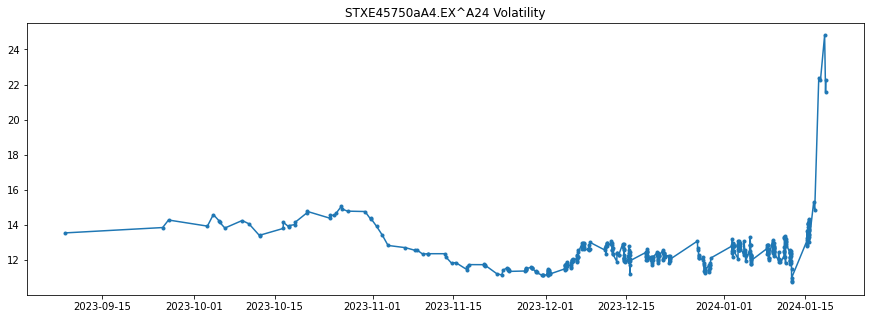

In [7]:
IIVNGIPAC_exp_optn_test3.simple_graph()

In [8]:
IIVNGIPAC_exp_optn_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').overlay().fig

In [9]:
IIVNGIPAC_exp_optn_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').stack3().fig

In [10]:
print("Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) expiered option test At Trade only:")
IIVNGIPAC_exp_optn_AT_test1 = IndxImpVolatNGreeksIPACalc(
    time_of_calc_datetime=datetime.strptime("2023-04-01", '%Y-%m-%d'),
    after=15,
    index_underlying=".STOXX50E",
    call_put='Call')
IIVNGIPAC_exp_optn_AT_test2: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_exp_optn_AT_test1.search_index_opt_ATM(
    debug=False,
    call_or_put='Put',
    search_fields=["ExchangeCode", "UnderlyingQuoteName"],
    include_weekly_opts=False,
    top_nu_srch_results=10)
IIVNGIPAC_exp_optn_AT_test3: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_exp_optn_AT_test2.IPA_calc(
    debug=False,
    AT_opn_trade_only=True)
print(f"IIVNGIPAC_exp_optn_AT_test3.instrument: {IIVNGIPAC_exp_optn_AT_test3.instrument}")
print(f"IIVNGIPAC_exp_optn_AT_test3.ATM_opt: {IIVNGIPAC_exp_optn_AT_test3.ATM_opt}")
print(f"IIVNGIPAC_exp_optn_AT_test3.maturity: {IIVNGIPAC_exp_optn_AT_test3.maturity}")
if pd.to_datetime(IIVNGIPAC_exp_optn_AT_test3.maturity) > datetime.now():
    print(f"IIVNGIPAC_exp_optn_AT_test3.instrument_info:")
    display(IIVNGIPAC_exp_optn_AT_test3.instrument_info)

Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) expiered option test At Trade only:
IIVNGIPAC_exp_optn_AT_test3.instrument: STXE45750aD3.EX^D23
IIVNGIPAC_exp_optn_AT_test3.ATM_opt: STXE45750aD3.EX^D23
IIVNGIPAC_exp_optn_AT_test3.maturity: 2023-04-21 00:00:00


In [11]:
IIVNGIPAC_exp_optn_AT_test3.IPA_df.dropna()

,STXE45750aD3.EX^D23,MarketValueInDealCcy,RiskFreeRatePercent,UnderlyingPrice,Volatility,DeltaPercent,GammaPercent,RhoPercent,ThetaPercent,VegaPercent
gmt,Romance Standard Time,,,,,,,,,
2023-01-26 15:50:00,2023-01-26 16:50:00+01:00,7.9,2.468,4168.03,13.116838,0.069622,0.000508,0.652278,-0.201532,2.674415
2023-02-06 08:20:00,2023-02-06 09:20:00+01:00,8.3,2.565,4214.71,12.842759,0.077425,0.000596,0.641735,-0.232177,2.741436
2023-02-06 11:20:00,2023-02-06 12:20:00+01:00,7.3,2.565,4190.61,13.143285,0.068492,0.000533,0.563492,-0.215614,2.479675
2023-02-08 11:20:00,2023-02-08 12:20:00+01:00,9.0,2.608,4230.42,12.808111,0.083836,0.000641,0.677383,-0.251034,2.879623
2023-02-09 08:00:00,2023-02-09 09:00:00+01:00,10.6,2.607,4250.46,12.820824,0.096189,0.00071,0.771039,-0.280899,3.184845
...,...,...,...,...,...,...,...,...,...,...
2023-04-17 07:40:00,2023-04-17 08:40:00+01:00,0.5,3.052,4395.08,17.377854,0.016866,0.000505,0.008685,-0.402787,0.199885
2023-04-17 08:00:00,2023-04-17 09:00:00+01:00,0.6,3.052,4387.39,18.539982,0.018795,0.000521,0.009625,-0.471263,0.218487
2023-04-18 09:50:00,2023-04-18 10:50:00+01:00,0.3,3.052,4394.35,18.814203,0.011319,0.000383,0.004355,-0.357881,0.122448


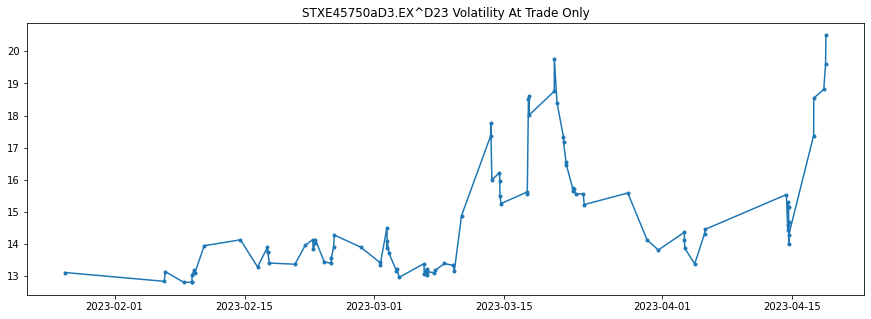

In [12]:
IIVNGIPAC_exp_optn_AT_test3.simple_graph()

In [13]:
IIVNGIPAC_exp_optn_AT_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').overlay().fig

In [14]:
IIVNGIPAC_exp_optn_AT_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').stack3().fig

In [15]:
print("Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) non expiered option test:")
IIVNGIPAC_optn_test1 = IndxImpVolatNGreeksIPACalc(
    after=15,
    index_underlying=".STOXX50E",
    call_put='Call')
IIVNGIPAC_optn_test2: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_optn_test1.search_index_opt_ATM(
    debug=False,
    call_or_put='Put',
    search_fields=["ExchangeCode", "UnderlyingQuoteName"],
    include_weekly_opts=False,
    top_nu_srch_results=10)
IIVNGIPAC_optn_test3: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_optn_test2.IPA_calc(
    date_back=30,
    debug=False,
    AT_opn_trade_only=False)
print(f"IIVNGIPAC_optn_test3.instrument: {IIVNGIPAC_optn_test3.instrument}")
print(f"IIVNGIPAC_optn_test3.ATM_opt: {IIVNGIPAC_optn_test3.ATM_opt}")
print(f"IIVNGIPAC_optn_test3.maturity: {IIVNGIPAC_optn_test3.maturity}")
if pd.to_datetime(IIVNGIPAC_optn_test3.maturity) > datetime.now():
    print(f"IIVNGIPAC_optn_test3.instrument_info:")
    display(IIVNGIPAC_optn_test3.instrument_info)

Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) non expiered option test:
IIVNGIPAC_optn_test3.instrument: STXE46000N4.EX
IIVNGIPAC_optn_test3.ATM_opt: STXE46000N4.EX
IIVNGIPAC_optn_test3.maturity: 2024-02-16 00:00:00
IIVNGIPAC_optn_test3.instrument_info:


,DocumentTitle,RIC,StrikePrice,UnderlyingQuoteRIC,ExpiryDate,ExchangeCode,UnderlyingQuoteName
4,Eurex EURO STOXX 50 Monthly Index Option 4600 ...,STXE46000N4.EX,4600,[.STOXX50E],2024-02-16,EUX,ESTX 50 PR INDEX


We are aware of the API limitations causing the error above. We are investigating it and will update this article in due time.

In [19]:
IIVNGIPAC_optn_test3.IPA_df.dropna()

,STXE46000N4.EX,MarketValueInDealCcy,RiskFreeRatePercent,UnderlyingPrice,Volatility,DeltaPercent,GammaPercent,RhoPercent,ThetaPercent,VegaPercent
gmt,Romance Standard Time,,,,,,,,,
2023-12-15 12:40:00,2023-12-15 13:40:00+01:00,98.1,3.92,4554.24,15.518803,0.45586,0.001343,3.419347,-0.947015,7.471918
2023-12-15 12:50:00,2023-12-15 13:50:00+01:00,98.1,3.92,4554.04,15.531884,0.455644,0.001342,3.417111,-0.947727,7.470753
2023-12-15 13:00:00,2023-12-15 14:00:00+01:00,98.1,3.92,4549.85,15.787349,0.451196,0.00132,3.378454,-0.960468,7.454154
2023-12-15 13:10:00,2023-12-15 14:10:00+01:00,98.1,3.92,4549.68,15.798533,0.451018,0.001319,3.376551,-0.96108,7.453077
2023-12-15 13:20:00,2023-12-15 14:20:00+01:00,98.1,3.92,4555.32,15.456353,0.457031,0.001349,3.427905,-0.944126,7.474345
...,...,...,...,...,...,...,...,...,...,...
2024-01-25 14:30:00,2024-01-25 15:30:00+01:00,76.0,3.929,4572.81,18.935699,0.474467,0.001873,1.262523,-2.142678,4.469661
2024-01-25 14:40:00,2024-01-25 15:40:00+01:00,76.0,3.929,4576.79,18.513929,0.48108,0.001916,1.28151,-2.106942,4.476989
2024-01-25 14:50:00,2024-01-25 15:50:00+01:00,59.1,3.929,4580.45,14.350244,0.479959,0.00247,1.289259,-1.68618,4.479247


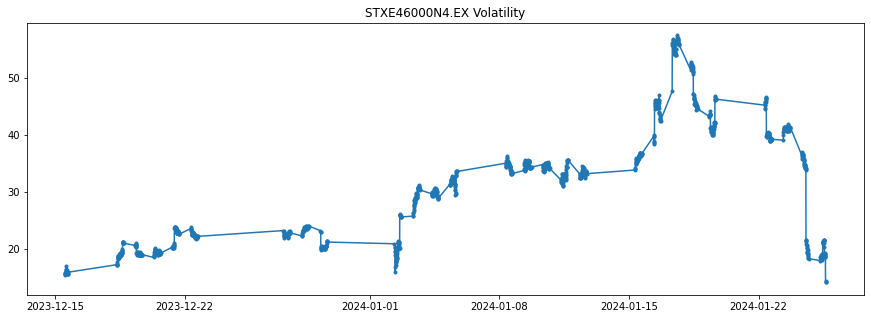

In [20]:
IIVNGIPAC_optn_test3.simple_graph()

In [21]:
IIVNGIPAC_optn_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').overlay().fig

In [22]:
IIVNGIPAC_optn_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').stack3().fig

In [23]:
print("Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) non expiered option test At Trade only:")
IIVNGIPAC_optn_AT_test1 = IndxImpVolatNGreeksIPACalc(
    after=15,
    index_underlying=".STOXX50E",
    call_put='Call')
IIVNGIPAC_optn_AT_test2: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_optn_AT_test1.search_index_opt_ATM(
    debug=False,
    call_or_put='Put',
    search_fields=["ExchangeCode", "UnderlyingQuoteName"],
    include_weekly_opts=False,
    top_nu_srch_results=10)
IIVNGIPAC_optn_AT_test3: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_optn_AT_test2.IPA_calc(
    debug=False,
    AT_opn_trade_only=False)
print(f"IIVNGIPAC_optn_AT_test3.instrument: {IIVNGIPAC_optn_AT_test3.instrument}")
print(f"IIVNGIPAC_optn_AT_test3.ATM_opt: {IIVNGIPAC_optn_AT_test3.ATM_opt}")
print(f"IIVNGIPAC_optn_AT_test3.maturity: {IIVNGIPAC_optn_AT_test3.maturity}")
if pd.to_datetime(IIVNGIPAC_optn_AT_test3.maturity) > datetime.now():
    print(f"IIVNGIPAC_optn_AT_test3.instrument_info:")
    display(IIVNGIPAC_optn_AT_test3.instrument_info)

Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) non expiered option test At Trade only:
IIVNGIPAC_optn_AT_test3.instrument: STXE46000N4.EX
IIVNGIPAC_optn_AT_test3.ATM_opt: STXE46000N4.EX
IIVNGIPAC_optn_AT_test3.maturity: 2024-02-16 00:00:00
IIVNGIPAC_optn_AT_test3.instrument_info:


,DocumentTitle,RIC,StrikePrice,UnderlyingQuoteRIC,ExpiryDate,ExchangeCode,UnderlyingQuoteName
4,Eurex EURO STOXX 50 Monthly Index Option 4600 ...,STXE46000N4.EX,4600,[.STOXX50E],2024-02-16,EUX,ESTX 50 PR INDEX


In [24]:
IIVNGIPAC_optn_AT_test3.IPA_df.dropna()

,STXE46000N4.EX,MarketValueInDealCcy,RiskFreeRatePercent,UnderlyingPrice,Volatility,DeltaPercent,GammaPercent,RhoPercent,ThetaPercent,VegaPercent
gmt,Romance Standard Time,,,,,,,,,
2024-01-24 13:30:00,2024-01-24 14:30:00+01:00,76.4,3.929,4549.21,21.586364,0.43204,0.00159,1.193588,-2.131688,4.488407
2024-01-24 13:40:00,2024-01-24 14:40:00+01:00,75.9,3.929,4548.02,21.592562,0.430159,0.001589,1.187818,-2.130205,4.482876
2024-01-24 13:50:00,2024-01-24 14:50:00+01:00,75.7,3.929,4549.54,21.405191,0.4318,0.001604,1.192712,-2.114678,4.486921
2024-01-24 14:00:00,2024-01-24 15:00:00+01:00,75.8,3.929,4549.94,21.392232,0.432375,0.001605,1.19405,-2.114475,4.487752
2024-01-24 14:10:00,2024-01-24 15:10:00+01:00,73.7,3.929,4551.78,20.750299,0.43272,0.001655,1.19651,-2.053651,4.489555
...,...,...,...,...,...,...,...,...,...,...
2024-01-25 14:30:00,2024-01-25 15:30:00+01:00,76.0,3.929,4572.81,18.935699,0.474467,0.001873,1.262523,-2.142678,4.469661
2024-01-25 14:40:00,2024-01-25 15:40:00+01:00,76.0,3.929,4576.79,18.513929,0.48108,0.001916,1.28151,-2.106942,4.476989
2024-01-25 14:50:00,2024-01-25 15:50:00+01:00,59.1,3.929,4580.45,14.350244,0.479959,0.00247,1.289259,-1.68618,4.479247


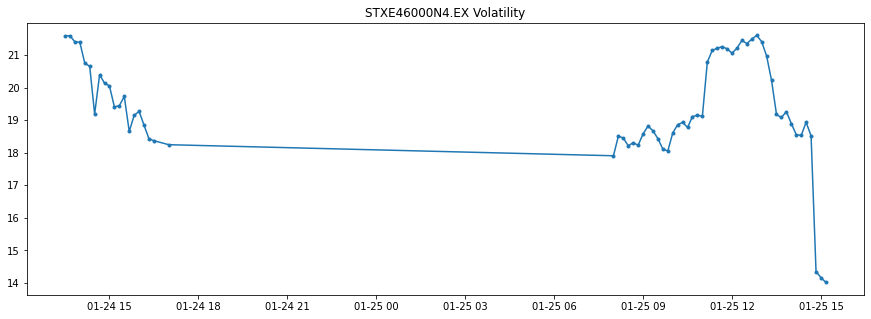

In [25]:
IIVNGIPAC_optn_AT_test3.simple_graph()

In [26]:
IIVNGIPAC_optn_AT_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').overlay().fig

In [27]:
IIVNGIPAC_optn_AT_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').stack3().fig

In [28]:
rd.close_session() # close the RD session opend at the start

## Conclusion

As you can see, not only can we use IPA to gather large amounts of bespoke, calculated, values, but be can also portray this insight in a simple, quick and relevent way!

## References

[Brilliant: Black-Scholes-Merton](https://brilliant.org/wiki/black-scholes-merton/)

[What is the RIC syntax for options in Refinitiv Eikon?](https://my.refinitiv.com/content/mytr/en/faqs/2016/09/000195632.html)

[Functions to find Option RICs traded on different exchanges](https://developers.refinitiv.com/en/article-catalog/article/functions-to-find-option-rics-traded-on-different-exchanges#2.4-Function-for-the-EUREX)

[Eikon Calc Help Page](https://emea1.apps.cp.thomsonreuters.com/Apps/AdfinLibrary/?cshid=AdBondDeriv&srv=PLNP-ERPCPRP04)

[Making your code faster: Cython and parallel processing in the Jupyter Notebook](https://www.youtube.com/watch?v=MiHddLYZ6cQhttps://www.youtube.com/watch?v=MiHddLYZ6cQ)

[What Happens to Options When a Stock Splits?](https://www.youtube.com/watch?v=rnTREPigNns)

[Select column that has the fewest NA values](https://stackoverflow.com/questions/50496618/select-column-that-has-the-fewest-na-values)

[Return Column(s) if they Have a certain Percentage of NaN Values (Python)](https://stackoverflow.com/questions/59161809/return-columns-if-they-have-a-certain-percentage-of-nan-values-python)

[How to Split a String Between Numbers and Letters?](https://www.youtube.com/watch?v=iu2lAZJfXHo)

### Q&A

[RIC nomenclature for expired Options on Futures](https://community.developers.refinitiv.com/questions/82796/ric-nomenclature-for-expired-options-on-futures.html)

[Expiration Dates for Expired Options API](https://community.developers.refinitiv.com/questions/69830/expiration-dates-for-expired-options-api.html)

[Measure runtime of a Jupyter Notebook code cellMeasure runtime of a Jupyter Notebook code cell](https://stackoverflow.com/questions/43307653/measure-runtime-of-a-jupyter-notebook-code-cellhttps://stackoverflow.com/questions/43307653/measure-runtime-of-a-jupyter-notebook-code-cell)

[What does these parameters mean in jupyter notebook when I input "%%time"?What does these parameters mean in jupyter notebook when I input "%%time"?](https://stackoverflow.com/questions/48202900/what-does-these-parameters-mean-in-jupyter-notebook-when-i-input-timehttps://stackoverflow.com/questions/48202900/what-does-these-parameters-mean-in-jupyter-notebook-when-i-input-time)